# Thematic differences (Slovenia)

DHH23 Parliament group

Author: Pontus H.

In [120]:
# Set the theme here
THEME = 'war_SI'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [121]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd
import numpy as np

In [122]:
# Optional stopwords
with open('../data/SloStopWords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()
stopwords = [word[:-1] for word in stopwords]

Set up the BERTopic pipeline

In [123]:
df = pd.read_csv(f'../data/{THEME}.csv')

In [124]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = int(np.sqrt(len(df)))
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0
OUTLIER_THRESHOLD = 0.1

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [125]:
df['Speaker_party'].describe()

count     9305
unique      24
top        SDS
freq      2413
Name: Speaker_party, dtype: object

In [126]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [127]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=OUTLIER_THRESHOLD)

In [128]:
pd.Series(new_topics).value_counts()

 0     2603
 1     1221
 2      884
 3      822
-1      696
 4      673
 5      487
 7      309
 6      288
 8      200
 13     199
 9      198
 14     185
 10     165
 12     147
 11     142
 15     133
dtype: int64

In [129]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [130]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [131]:
# Number of topics
print(f"Number of topics: {len(pd.Series(new_topics).unique())}")

Number of topics: 17


In [132]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     2599
 4     2391
 13     999
 11     628
 9      526
 12     418
 1      404
 6      198
 14     174
 3      162
 2      140
 0      134
 5      124
 15     119
 8      119
 7      117
 10     100
dtype: int64

In [133]:
topic_model.visualize_topics()

In [134]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
# Create the output directory if it does not exist
import os
if not os.path.exists(f"{OUTPUT_PATH}{THEME}"):
    os.makedirs(f"{OUTPUT_PATH}{THEME}")
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}/{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

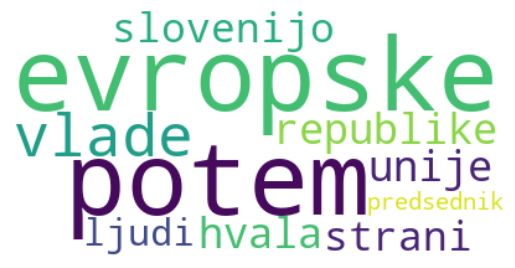

In [135]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [136]:
#topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [137]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
#get_keywords(0)

In [138]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('SDS|SD'), 'party'] = 'OTHER'
# Set the party name to 'OTHER' if the party name is 'ZLSD'
speech_topic_party.loc[speech_topic_party['party'] == 'ZLSD', 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
#speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,OTHER,SD,SDS
topic,,,
0,1595,245,750
1,678,156,385
2,549,111,218
3,462,126,231
4,464,74,129
5,323,65,98
6,194,47,46
7,144,42,122
8,139,28,32


In [139]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,OTHER,SD,SDS
topic,,,
0,34.2,26.3,36.6
1,14.5,16.8,18.8
2,11.8,11.9,10.6
3,9.9,13.5,11.3
4,9.9,7.9,6.3
5,6.9,7.0,4.8
6,4.2,5.0,2.2
7,3.1,4.5,6.0
8,3.0,3.0,1.6


In [140]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
#percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,OTHER,SD,SDS,keywords
topic,,,,
0,34.2,26.3,36.6,"[evropske, potem, vlade, republike, unije, hva..."
1,14.5,16.8,18.8,"[danes, lahko, tukaj, vlade, rekel, ministra, ..."
2,11.8,11.9,10.6,"[zakon, gre, hvala, sedaj, stvari, vlada, drža..."
3,9.9,13.5,11.3,"[vojska, obrambo, republike, slovenije, hvala,..."
4,9.9,7.9,6.3,"[milijonov, evrov, proračunu, rast, javnih, in..."
5,6.9,7.0,4.8,"[žrtev, grobišča, kulturne, invalidih, odškodn..."
6,4.2,5.0,2.2,"[pokojninske, starejših, vdovske, evrov, zavar..."
7,3.1,4.5,6.0,"[komisije, obveščevalnih, gospod, poročila, pa..."
8,3.0,3.0,1.6,"[policijo, notranje, organiziranosti, direktor..."


In [141]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
#percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,OTHER,SD,SDS
0,0,61.6,9.5,29.0
1,1,55.6,12.8,31.6
2,2,62.5,12.6,24.8
3,3,56.4,15.4,28.2
4,4,69.6,11.1,19.3
5,5,66.5,13.4,20.2
6,6,67.6,16.4,16.0
7,7,46.8,13.6,39.6
8,8,69.8,14.1,16.1
9,9,61.6,18.7,19.7


Calculate mean sentiment for each topic per party

In [142]:
#sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'speech_id': df['ID'], 'party': df['Speaker_party'], 'sentiment': df['sentiment'], 'speech_date': df['Date'], 'prob': list(probs), 'speech': df['speech']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('SDS|SD'), 'party'] = 'OTHER'
# Set the party name to 'OTHER' if the party name is 'ZLSD'
sentiment_topic_party.loc[sentiment_topic_party['party'] == 'ZLSD', 'party'] = 'OTHER'
# Create a new dataframe with the relevant speeches and remove
relevant_speeches = sentiment_topic_party.copy()
sentiment_topic_party.drop(columns=['speech', 'speech_date', 'prob'], inplace=True)
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
#sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,OTHER,SD,SDS
topic,,,
0,-0.38,-0.37,-0.52
1,-0.59,-0.60,-0.64
2,-0.46,-0.50,-0.50
3,-0.23,-0.12,-0.25
4,-0.37,-0.35,-0.41
5,-0.36,-0.20,-0.33
6,-0.32,-0.32,-0.30
7,-0.63,-0.47,-0.52
8,-0.34,-0.24,-0.36


In [143]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")

In [144]:
def get_top_3(topic_id, party_name):
    speeches_for_topic_0_con = relevant_speeches[(relevant_speeches['party'] == party_name) & (relevant_speeches['topic'] == topic_id)]
    speeches_for_topic_0_con['prob'] = speeches_for_topic_0_con['prob'].apply(lambda x: x[topic_id])
    speeches_for_topic_0_con = speeches_for_topic_0_con.sort_values(by='sentiment', ascending=False)
    most_positive = speeches_for_topic_0_con.head(3)
    most_negative = speeches_for_topic_0_con.tail(3)
    return most_positive.append(most_negative).drop_duplicates(subset=['speech_id'])

parties = ['SDS', 'SD', 'OTHER']

max_topic = relevant_speeches['topic'].max()

representative_speeches = get_top_3(0, 'SDS')
for party in parties[1:]:
    representative_speeches = representative_speeches.append(get_top_3(0, party))
for topic_id in range(1,max_topic+1):
    for party in parties:
        representative_speeches = representative_speeches.append(get_top_3(topic_id, party))

# Save the representative speeches to a csv and feather file. Use '"" as the quotechar to avoid issues with the speech text
representative_speeches.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.csv', quotechar='"', index=False)
representative_speeches.reset_index().to_feather(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.feather')
representative_speeches

,topic,speech_id,party,sentiment,speech_date,prob,speech
2201,0,ParlaMint-SI_2013-04-02-SDZ6-Redna-12.u22,SDS,0.926758,2013-04-02,0.990151,"Spoštovani predsednik, predsednica Vlade z min..."
6560,0,ParlaMint-SI_2016-06-08-SDZ7-Izredna-33.u6,SDS,0.794922,2016-06-08,0.994137,"Hvala za besedo, gospod predsednik. Spoštovani..."
2711,0,ParlaMint-SI_2015-03-09-SDZ7-Redna-05.u62,SDS,0.734863,2015-03-09,0.398359,Spoštovani! Ena od temeljnih vrednot Slovenske...
5504,0,ParlaMint-SI_2009-05-25-SDZ5-Redna-06.u78,SDS,-1.000000,2009-05-25,0.991696,Hvala lepa za besedo. Žal je moja prva ugotovi...
6903,0,ParlaMint-SI_2016-02-22-SDZ7-Izredna-28.u20,SDS,-1.000000,2016-02-22,0.255516,Hvala še enkrat za besedo. Vsem še enkrat prav...
...,...,...,...,...,...,...,...
8973,9,ParlaMint-SI_2019-10-22-SDZ8-Redna-12.u260,OTHER,0.654785,2019-10-22,0.028379,"Hvala lepa, predsedujoči, za besedo. Spoštovan..."
4853,9,ParlaMint-SI_2014-04-23-SDZ6-Redna-24.u114,OTHER,0.622559,2014-04-23,0.990030,Hvala za besedo. Vsem skupaj prav lep pozdrav!...
3466,9,ParlaMint-SI_2006-03-28-SDZ4-Redna-15.u170,OTHER,-1.000000,2006-03-28,0.022279,"Cenjene kolegice, cenjeni kolegi, spoštovani p..."
6279,9,ParlaMint-SI_2005-06-20-SDZ4-Izredna-09.u460,OTHER,-1.000000,2005-06-20,0.992559,Hvala lepa. V zvezi s tem amandmajem moram pov...


In [145]:
# Create a new dataframe from percentages, percentages_per_row and sentiment_topic_party
concatenated_results = pd.concat([percentages, percentages_per_row, sentiment_topic_party], axis=1)
# Rename the columns to make it easier to understand
concatenated_results.columns = ['pf.OTHER', 'pf.SD', 'pf.SDS', 'keywords', 'tc.OTHER', 'tc.SD', 'tc.SDS', 's.OTHER', 's.SD', 's.SDS']
# Reorder the columns
concatenated_results = concatenated_results[['keywords', 'tc.SDS', 'tc.SD', 'tc.OTHER', 'pf.SDS', 'pf.SD', 'pf.OTHER', 's.SDS', 's.SD', 's.OTHER']]
# Save the results to a csv
concatenated_results.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_results.csv')
concatenated_results

,keywords,tc.SDS,tc.SD,tc.OTHER,pf.SDS,pf.SD,pf.OTHER,s.SDS,s.SD,s.OTHER
topic,,,,,,,,,,
0,"[evropske, potem, vlade, republike, unije, hva...",29.0,9.5,61.6,36.6,26.3,34.2,-0.52,-0.37,-0.38
1,"[danes, lahko, tukaj, vlade, rekel, ministra, ...",31.6,12.8,55.6,18.8,16.8,14.5,-0.64,-0.60,-0.59
2,"[zakon, gre, hvala, sedaj, stvari, vlada, drža...",24.8,12.6,62.5,10.6,11.9,11.8,-0.50,-0.50,-0.46
3,"[vojska, obrambo, republike, slovenije, hvala,...",28.2,15.4,56.4,11.3,13.5,9.9,-0.25,-0.12,-0.23
4,"[milijonov, evrov, proračunu, rast, javnih, in...",19.3,11.1,69.6,6.3,7.9,9.9,-0.41,-0.35,-0.37
5,"[žrtev, grobišča, kulturne, invalidih, odškodn...",20.2,13.4,66.5,4.8,7.0,6.9,-0.33,-0.20,-0.36
6,"[pokojninske, starejših, vdovske, evrov, zavar...",16.0,16.4,67.6,2.2,5.0,4.2,-0.30,-0.32,-0.32
7,"[komisije, obveščevalnih, gospod, poročila, pa...",39.6,13.6,46.8,6.0,4.5,3.1,-0.52,-0.47,-0.63
8,"[policijo, notranje, organiziranosti, direktor...",16.1,14.1,69.8,1.6,3.0,3.0,-0.36,-0.24,-0.34
